In [1]:
# Configuration of policy-CEM-method
from yacs.config import CfgNode as CN

_C = CN()
_C.SYSTEM = CN()
_C.SYSTEM.DEVICES = []
_C.SYSTEM.VIRTUAL_SCREEN = (600, 400)
_C.SYSTEM.PRINT_EVERY = 10

_C.AGENT = CN()
_C.AGENT.MAX_N_STEPS = 1000
_C.AGENT.GAMMA = 1.0
_C.AGENT.LR = 0.001

_C.GAME_ENV = CN()
_C.GAME_ENV.N_ITERATIONS = 2000
_C.GAME_ENV.NOISE_SIGMA = 0.5

def get_cfg_defaults():
    return _C.clone()

In [2]:
import gym
import os
import numpy as np
from pyvirtualdisplay import Display
from collections import deque
import torch
from collections import deque

#from cartpole.config import get_cfg_defaults
#from cartpole.utils import ReplayMemory, screen_to_state
cfg = get_cfg_defaults()

devices = ",".join(str(i) for i in cfg.SYSTEM.DEVICES)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = devices

torch_devices = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
display = Display(visible=0, size=cfg.SYSTEM.VIRTUAL_SCREEN)
display.start()
env = gym.make("CartPole-v0")
#env = gym.make("MountainCar-v0")

In [4]:
# agent.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict

class Agent_REINFORCE(nn.Module):
    def __init__(self, input_size, output_size, device="cpu"):
        super(Agent_REINFORCE, self).__init__()
        self.device = device
        
        self.layer1 = nn.Linear(input_size, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, output_size, bias=False)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return F.softmax(self.layer3(x), dim=0) # action = 0 or 1 (discrete)
    
    
    def get_weights_dim(self):
        # return numbers of parameters of layers --> n in flatten form
        return [len(param.reshape(-1).detach().numpy()) for param in self.parameters()]
    
    def set_weights(self, weights):
        new_network_state = self._pair_weight_key_to_weight(weights=weights)
        self.load_state_dict(new_network_state)
        
    def act(self, state):
        """Given a state, return a action and its logloss"""
        state = torch.from_numpy(state).float().to(self.device)
        probs = self.forward(state)
        
        sampler = torch.distributions.Categorical(probs) # kind of random.sample(prob)
        action = sampler.sample()
        
        return action.item(), sampler.log_prob(action)
        
    """
    def evaluate(self, env, weights, gamma=1.0, max_n_steps=5000):
        self.set_weights(weights)
        state = env.reset()
        rewards = 0.
        for t in range(max_n_steps):
            state = torch.from_numpy(state).float().to(self.device)
            action = self.forward(state).detach().numpy()
            #action = int(np.round(action)) # cartpole-v0 only accept 0 or 1 (no float between 0-1)
            action = np.argmax(action) # cartpole-v0 only accept 0 or 1 (no float between 0-1)
            next_state, reward, done, _ = env.step(action)
            rewards += reward * gamma**t
            state = next_state
            if done:
                break
        return rewards
    """ 
    
    def _pair_weight_key_to_weight(self, weights):
        """pair key and weights
        Args:
          weights: list of 1D-vectors n * [n_weights]
          
        Returns: A reshaped, mapped state_dict
        """
        keys = list(self.state_dict().keys())
        original_weight_shape = [list(param.shape) for param in self.parameters()]
        return OrderedDict({k:torch.from_numpy(v).reshape(s) for k, v, s in zip(keys, weights, original_weight_shape)})
        

In [5]:
agent = Agent_REINFORCE(input_size=env.observation_space.shape[0], 
                        output_size=env.action_space.n, 
                        device=torch_devices).to(torch_devices)
#optimizer = optim.Adam(agent.parameters(), lr=cfg.AGENT.LR)
optimizer = optim.RMSprop(agent.parameters(), lr=cfg.AGENT.LR)

In [6]:
def run(n_episode=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episode+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        
        for t in range(max_t):
            action, log_prob = agent.act(state)
            saved_log_probs.append(log_prob)
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            state = next_state
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # gamma=1 means focus on now, and discount former experiences, so we reverse it
        discounts = [gamma**i for i in range(len(rewards)+1)][::-1] 
        R = sum([a*b for a,b in zip(rewards, discounts)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.stack(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print("Episode {} Average Score: {:.2f}".format(i_episode, np.mean(scores_deque)))
            
    return scores

In [7]:
scores = run(n_episode=cfg.GAME_ENV.N_ITERATIONS, 
             max_t=cfg.AGENT.MAX_N_STEPS, 
             gamma=cfg.AGENT.GAMMA)

Episode 100 Average Score: 25.12
Episode 200 Average Score: 26.67
Episode 300 Average Score: 35.63
Episode 400 Average Score: 36.77
Episode 500 Average Score: 49.61
Episode 600 Average Score: 51.77
Episode 700 Average Score: 53.78
Episode 800 Average Score: 67.93
Episode 900 Average Score: 93.27
Episode 1000 Average Score: 117.53
Episode 1100 Average Score: 113.85
Episode 1200 Average Score: 124.85
Episode 1300 Average Score: 137.93
Episode 1400 Average Score: 133.08
Episode 1500 Average Score: 133.34
Episode 1600 Average Score: 150.12
Episode 1700 Average Score: 150.86
Episode 1800 Average Score: 177.13
Episode 1900 Average Score: 182.46
Episode 2000 Average Score: 165.46


## After training, we examine the trained model

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

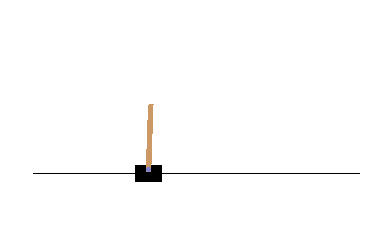

In [8]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
elapse_time = 0
total_reward = 0
while True & (elapse_time < 100000):
    print(state)
    state = torch.from_numpy(state).float().to(torch_devices)
    with torch.no_grad():
        action = agent(state)
    action = int(np.argmax(action))
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state
    elapse_time+=1
    if done:
        break

env.close()